In [313]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set(style="whitegrid")

from api.questrade import QTClient

In [317]:
REFRESH_TOKEN = "dVAAL1gGeFHky8i4ltw4qdQWZlIcECUx0"

In [318]:
client = QTClient(REFRESH_TOKEN)

# Show Open PnL

In [319]:
positions = pd.DataFrame(client.get_account_positions())
positions

,averageEntryPrice,closedPnl,closedQuantity,currentMarketValue,currentPrice,dayPnl,isRealTime,isUnderReorg,openPnl,openQuantity,symbol,symbolId,totalCost
0,40.800000,0,0,192.65,38.53,-1.70,False,False,-11.350000,5,ROBO,4807280,204.000000
1,23.510000,0,0,240.20,24.02,-7.10,False,False,5.100000,10,TAN,21806477,235.100000
2,23.398317,0,0,234.24,19.52,-2.16,False,False,-46.539804,12,BOTZ,15029143,280.779804


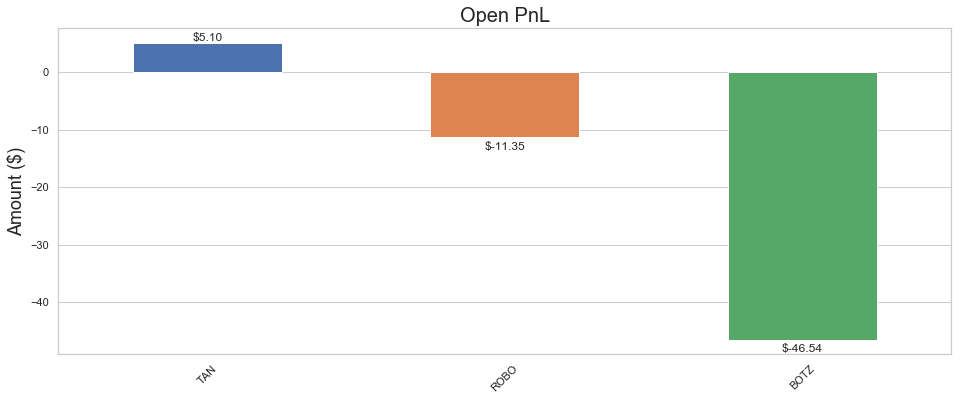

In [320]:
%matplotlib inline
positions.sort_values(by=['openPnl'], inplace=True, ascending=False)
ax = positions.plot(x='symbol', y='openPnl', kind='bar', figsize=(16, 6), legend=False)
ax.set_title('Open PnL', fontsize=20)
ax.set_ylabel('Amount ($)', fontsize=18)
ax.set_xlabel('')
ax.grid(axis='x')
rects = ax.patches
for rect, label in zip(rects, positions['openPnl']):
    height = rect.get_height()
    if height < 0:
        height -= 2.5
    ax.text(rect.get_x() + rect.get_width() / 2, height, '$%.2f' % label,
            ha='center', va='bottom', fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [321]:
print("Open PnL: %f" % (positions['openPnl'].sum()))

Open PnL: -52.789804


# Stitch market data for all securities into one DataFrame

## Add other securities to the list

In [322]:
symbols = dict(zip(positions["symbolId"], positions["symbol"]))
additional_securities = [

]

for symbol in additional_securities:
    matched_securities = client.search(symbol)
    if len(matched_securities) > 1:
        print("%s <=> %s" %(symbol, matched_securities[0]['symbol']))
        symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']

In [323]:
symbols

{21806477: 'TAN', 4807280: 'ROBO', 15029143: 'BOTZ'}

In [324]:
FROM_DATE = '2016-10-01T00:00:00-05:00'
TO_DATE = '2019-10-20T23:59:59-05:00'

historicals = pd.DataFrame()
for symbolId, symbol in symbols.items():
    candles = pd.DataFrame(client.get_candles(symbolId, FROM_DATE, TO_DATE, 'OneDay'))
    candles['end'] =  pd.to_datetime(candles['end'], format='%Y-%m-%d')
    candles['symbol'] = symbol
    candles['symbolId'] = symbol_id
    historicals = historicals.append(candles)
historicals = historicals.set_index(["symbol", "end"])

# Plot historical data

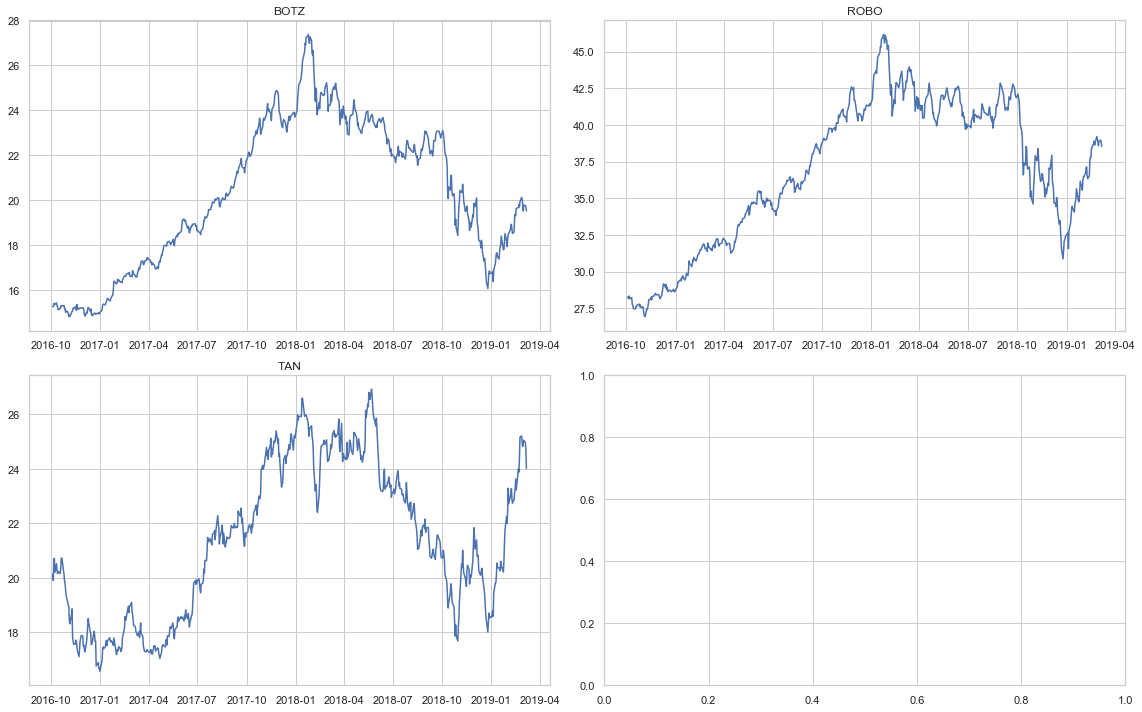

In [325]:
grouped = historicals.reset_index().set_index("end").groupby('symbol')
rows = math.ceil(grouped.ngroups / 2)                    
fig, axs = plt.subplots(figsize=(16,10), nrows=rows, ncols=2)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key)['close'])
    ax.set_title(key)

plt.tight_layout()
plt.show()

In [326]:
historicals['daily_returns'] = historicals.groupby(level='symbol')['close'].apply(lambda x: x.pct_change())
historicals['total_returns'] = historicals.groupby(level='symbol')['daily_returns'].apply(lambda x:                                                                                        (1 + x).cumprod() - 1)

symbol
BOTZ    AxesSubplot(0.125,0.2;0.775x0.68)
ROBO    AxesSubplot(0.125,0.2;0.775x0.68)
TAN     AxesSubplot(0.125,0.2;0.775x0.68)
Name: total_returns, dtype: object

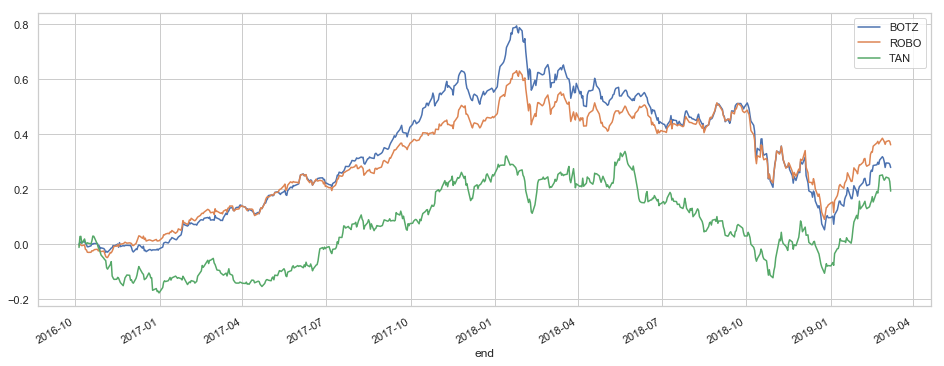

In [327]:
plt.figure(figsize=(16, 6))
historicals.reset_index().set_index("end").groupby('symbol')['total_returns'].plot(legend=True)

In [328]:
historicals.groupby(level="symbol")["total_returns"].nth(-1)

symbol
BOTZ    0.279438
ROBO    0.361845
TAN     0.193244
Name: total_returns, dtype: float64

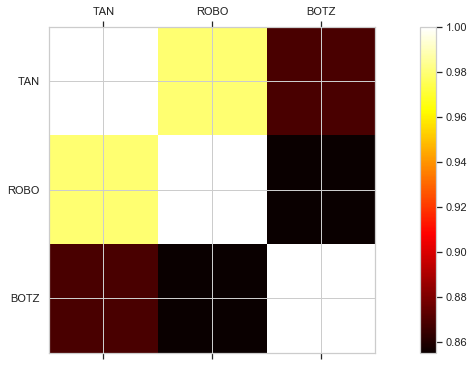

In [329]:
price_corr = historicals.reset_index().pivot('end','symbol')['close'].corr()

alpha = list(symbols.values())

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(price_corr, cmap='hot')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [330]:
price_corr

symbol,BOTZ,ROBO,TAN
symbol,,,
BOTZ,1.000000,0.979582,0.869125
ROBO,0.979582,1.000000,0.855089
TAN,0.869125,0.855089,1.000000
